In [2]:
!pip install rdflib
!pip install faker

from rdflib import Graph, Literal, RDF, URIRef, Namespace
from faker import Faker
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
import seaborn as sns
import scipy.stats as st
import pymc3 as pm
import re

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Data Pre-Processing

In [3]:
# Just viewing setting options
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

# Global Data Variables
fake = Faker()
g = Graph()

variableDTDict = {'Salary':'continuous','Age':'continuous','Experience':'discrete','Gender':'discrete','Education':'discrete','Ethnicity':'discrete', 'Personnel':'continuous'}

variableConstraintDict = {'Age':{'lowerBound':18, 'upperBound':65}, 'Salary':{'lowerBound':0, 'upperBound':1000000}}

variableDistDict = {'Salary':'lognorm','Age':'truncnorm','Experience':'histogram','Gender':'histogram','Education':'histogram','Ethnicity':'histogram', 'Personnel':'continuous'}

personnelVar = 'Personnel'


# Namespace of the Ontology
dbo = Namespace("http://dbpedia.org/ontology/")
codeOnto = Namespace("http://visualdataweb.org/syntheticontology/")

# Binding Namespaces
g.bind("codeOnto", 'http://visualdataweb.org/syntheticontology/')
g.bind("dbo", 'http://dbpedia.org/ontology/')

# Importing Ontology and RDF Knowledge Graph data
g.parse("CodeOntology.rdf")

<Graph identifier=Nc02ddff6e8bd4847a83fdaa837bd9e83 (<class 'rdflib.graph.Graph'>)>

In [4]:
# Getting the companies and their size in a dataframe from Knowledge base
cres = g.query(
    """SELECT ?s ?o
       WHERE {
           ?s rdf:type codeOnto:Company.
           ?s codeOnto:hasSize ?o.
       }""")

companyTriples = pd.DataFrame(cres, columns=["company","size"]).sort_values(by="company")

compDict = {}
for row in cres:
    company = row[0].rsplit('/', 1)[-1]    
    compDict[company] = str(row[1].rsplit('/', 1)[-1])
    
# compDict

In [5]:
# Selecting facts in form of triples into factTriples Dataframe

qres = g.query(
    """SELECT ?s ?p ?o
       WHERE {
           ?s rdf:type codeOnto:Fact.
           ?s ?p ?o.
       }""")

factTriples = pd.DataFrame(qres, columns=["subject", "property", "object"]).sort_values(by="subject")

factDict = {}


# Filtering the triple to properties and saving them to FactDF dataframe

for row in qres:
    factno = row[0].rsplit('/', 1)[-1]
    prop = row[1].rsplit('/', 1)[-1]
        
    if factno not in factDict:
        factDict[factno] = {}
    if prop in ['22-rdf-syntax-ns#type']:
        continue
    if prop in ['measureValue', 'hasCompany', 'hasSize', 'hasIndependent', 'hasDependent']:
        if prop == 'hasCompany':
            factDict[factno]['hasSize'] = compDict[(row[2].rsplit('/', 1)[-1])]
            continue
        if prop == 'hasIndependent':
            if 'hasIndependent' in factDict[factno]:
                factDict[factno]['hasIndependent'].append(str((row[2].rsplit('/', 1)[-1])))
            else:
                factDict[factno]['hasIndependent'] = [str((row[2].rsplit('/', 1)[-1]))]
            continue
            
        factDict[factno][prop] = str(row[2].rsplit('/', 1)[-1])
    else:
        factDict[factno][prop] = str(row[2])

FactDF = pd.DataFrame.from_dict(factDict, orient='index')

In [6]:
# FactDF.sort_values(by='hasDependent')
# FactDF.sort_values(by='hasSize')
# FactDF.sort_index()

# Functions

In [7]:
# Helper Function to convert list data type from float to int
def listFloatToInt(varList):
    return list(map(int, varList))

# Function to get only Independent fact rows of given variable
def getIndependentVariableData(Variable, Value):
    return FactDF[FactDF.apply(lambda x: (Value in x[Variable] and pd.isna(x["hasDependent"])), axis=1)]

# Get the cleaned array of the "hasValue" column of every fact
def getFiltteredData(varDF):
    varList = []
    for i in varDF['hasValue']:
        varList.append(i.split(':')[1][:-1])
    return varList

# Function to get the number of personnel to be generated
def getRandomPersonnelCount():
    personnelList = getFiltteredData(getIndependentVariableData("hasIndependent", personnelVar))
    personnelList = listFloatToInt(personnelList)
    print(len(personnelList))
    sns.distplot(personnelList, label='Personnel Fact Histogram')
    hist = np.histogram(personnelList, bins=1000)
    hist_dist = st.rv_histogram(hist)
#     sns.distplot(hist_dist.rvs(size=28), label='Simulation distribution x28')
    plt.legend()
    plt.show()
    return int(hist_dist.rvs(size=1))

# Get variables which are to be to ignored because they are indepedent variable but always have a depedent variable
def getIgnoringVariable():
    ff =[i for sub in filter(lambda x: len(x)==1, pd.unique(FactDF[~pd.isna(FactDF['hasDependent'])].apply(lambda x: tuple(x['hasIndependent']), axis=1))) for i in sub]
    return list(set(ff) - set(pd.unique(FactDF[FactDF['hasIndependent'].map(str).str.contains('|'.join(ff)) & pd.isna(FactDF['hasDependent'])]['hasIndependent'].map(lambda x: x[0]))))

# Function to get priorities to the variable when synthesizing
def getVariablePriority():
    variablePriority={'fullyIndependent':[], 'partialIndependent':[], 'fullyDependent':[]}

    uniqueIndependent = [i for sub in filter(lambda x: len(x)==1, pd.unique(FactDF[pd.isna(FactDF['hasDependent'])].apply(lambda x: tuple(x['hasIndependent']), axis=1))) for i in sub]
    uniqueDependent = FactDF['hasDependent'].dropna().unique()
    
    removedVar = getIgnoringVariable()

    variablePriority['partialIndependent'] = set(uniqueIndependent).intersection(set(uniqueDependent))
    variablePriority['fullyIndependent'] = set(uniqueIndependent) - variablePriority['partialIndependent']
    variablePriority['fullyDependent'] = set(uniqueDependent) - variablePriority['partialIndependent']
    
    partialIndependentTemp = dict()
    
    for i in range(len(variablePriority['partialIndependent'])):
        partialIndependentTemp[list(variablePriority['partialIndependent'])[i]] = i
    
    partialIndependent = partialIndependentTemp
    
    # Adjust Partial Independent priorities
    for i in partialIndependentTemp.keys():
        for k in FactDF[FactDF['hasDependent'] == i]['hasIndependent']:
            for l in k:
                if l not in uniqueIndependent and l not in removedVar:
                    if partialIndependent[l] > partialIndependent[i]:
                        temp = partialIndependent[l]
                        partialIndependent[l] = partialIndependent[i]
                        partialIndependent[i] = temp
        
    variablePriority['partialIndependent'] = partialIndependent
    
    for l in variablePriority:
        if personnelVar in variablePriority[l]:
            variablePriority[l].discard(personnelVar)
    
    return variablePriority

# Generating Data for Independent discrete variables
def getCategoricalColumnsData(variable):
    varList = getIndependentVariableData("hasIndependent", variable)
    genDf = pd.DataFrame()
    n = 0
    for i in varList['hasValue']:
        factArr = re.findall("\[(.*?)\]", i)
        genDf.at[n , 'Others'] = 0
        for j in factArr:
            factStr = j.split(',')
            genDf.at[n, factStr[0].split(':')[1].strip("'")] = float(factStr[1].split(':')[1])
        n = n+1    
    genDf = genDf.fillna(0)
    
    s = pd.DataFrame()
    for col in genDf.columns:
        s.at[0, col] = sum(genDf[col])/(len(genDf)*100)

    cols = s.columns
    col_id = s.columns.get_loc("Others") 
    cols = [*cols[:col_id], *cols[col_id+1:] , cols[col_id]]
    s = s[cols]
    category = list(s)
    probability = list(s.iloc[0])
    
    if sum(probability) != 1:
        probability[category.index('Others')] = probability[category.index('Others')] + (1-sum(probability))
    
    res = np.random.choice(category, noEmployee, p=probability)
    return res

# Generate random distribution of Trunc Normal type given Measure and Lower and Higher bound                                   
def generateTruncateDistributionsForMeanMedian(low, high, measure):
    mean = measure #Paper Reference - https://doi.org/10.1186/1471-2288-5-13
    std = ((high-low)/6) #Paper Reference - https://doi.org/10.1186/1471-2288-5-13

    a,b = (low-mean)/std, (high-mean)/std
    
    x = np.linspace(low,high,1000000)
    X = st.truncnorm.pdf(x,a,b,loc=mean,scale=std)
    
#     res = np.random.choice(x, size=1000, p=X/np.sum(X))
#     sns.distplot(res, hist=False)
    return X

# Generate random distribution of Log Normal type given Measure
def generateLogNormDistributionForMeanMedian(measure):
    mu = measure #Paper Reference - https://doi.org/10.1186/1471-2288-5-13
    sigma = mu/6 #Paper Reference - https://doi.org/10.1186/1471-2288-5-13
    
    normal_std = np.sqrt(np.log(1 + (sigma/mu)**2))
    normal_mean = np.log(mu) - normal_std**2 / 2

    x=np.linspace(0,1000000,1000000)
    X = st.lognorm.pdf(x,s=normal_std, scale=np.exp(normal_mean))
    return X

# Generating a aggregated distribution with each Independent fact associated with given variable - Expectation Maximization
def generateContinuousIndependentColumnsDistribution(variable):
    varList = getFiltteredData(getIndependentVariableData("hasIndependent", variable))
    i =  0
    high = variableConstraintDict[variable]['upperBound']
    low = variableConstraintDict[variable]['lowerBound']
    
    if variableDistDict[variable] == 'truncnorm':
        for a in varList:
            if i == 0:
                Z = generateTruncateDistributionsForMeanMedian(low,high,int(a))
            else:
                prior = Z
                likelihood = generateTruncateDistributionsForMeanMedian(low,high,int(a))
                Z = (prior + likelihood)
            i=i+1
    elif variableDistDict[variable] == 'lognorm':
        for a in varList:
            if i == 0:
                Z = generateLogNormDistributionForMeanMedian(int(a))
            else:
                prior = Z
                likelihood = generateLogNormDistributionForMeanMedian(int(a))
                Z = (prior + likelihood)
            i=i+1
            
    return Z

# Generating Data for Independent continuous variables
def generateContinuousIndependentColumnsData(variable):
    varList = getFiltteredData(getIndependentVariableData("hasIndependent", variable))
    i =  0
    high = variableConstraintDict[variable]['upperBound']
    low = variableConstraintDict[variable]['lowerBound']
    
    Z = generateContinuousIndependentColumnsDistribution(variable)
    x = np.linspace(low,high,1000000)
    res = np.random.choice(x, size=noEmployee, p=Z/np.sum(Z))
    
#     sns.distplot(res, hist=True, color="black", label="Aggregated Distribution")
#     plt.legend()
#     plt.show()
    
#     sns.distplot(res, kde=True)
#     print('Mean',np.mean(res))
#     print('sigma', np.std(res))
#     print('Median', np.median(res))
#     print('min', min(res))
#     print('max', max(res))
#     print(len(res))
    return res



# Get Independent and Dependent facts of the given variable
def getPartialDependentFacts(variable):
    ignoreVar = getIgnoringVariable()

    indepFacts = getIndependentVariableData("hasIndependent", variable).sort_values('hasSize')

    depenFacts = FactDF[FactDF['hasDependent'].notna()]
    depenFacts = depenFacts[~depenFacts['hasValue'].str.contains('|'.join(ignoreVar))]
    return indepFacts, depenFacts

# Generating Data for Partially Dependent continuous variables
def getPartialDependentColumnData(variable):
    inde, depe = getPartialDependentFacts(v)
    independentDistribution = generateContinuousIndependentColumnsDistribution(variable)
    dependentVariableDistributionDF = pd.DataFrame()
    
    for o in range(len(depe)):
        x = depe.iloc[o]
        factArr = re.findall("\[(.*?)\]", x["hasValue"][1:-1])
        for i in range(len(factArr)):
            idx = len(dependentVariableDistributionDF) + 1 
            hasValue = []
            dependentVariableDistributionDF.at[idx, "fact"] = x.name
            for j in factArr[i].split(',')[:-1]:
                hasValue.append(str(j.split(":")[1].strip("'").replace("'", "").strip()))
            dependentVariableDistributionDF.at[idx, "hasValue"] = list(hasValue)
            dependentVariableDistributionDF.at[idx, variable] = int(factArr[i].split(',')[-1].split(":")[1].strip())
    
    Z = independentDistribution
    high = variableConstraintDict[variable]['upperBound']
    low = variableConstraintDict[variable]['lowerBound']
    
    for l in range(len(empDF)):
        empset = set(empDF.iloc[l])
        for a in range(len(dependentVariableDistributionDF)):
            if type(dependentVariableDistributionDF.iloc[a]['hasValue']) == str:
                factset = set([dependentVariableDistributionDF.iloc[a]['hasValue']])
            else:
                factset = set(dependentVariableDistributionDF.iloc[a]['hasValue'])
            if len(factset-empset) == 0:
                prior = Z
                likelihood = generateLogNormDistributionForMeanMedian(dependentVariableDistributionDF.iloc[a][variable])
                Z = (prior+likelihood)
                
    x = np.linspace(low,high,1000000)
    res = np.random.choice(x, size=noEmployee, p=Z/np.sum(Z))
    
    return res

# Generating Data

In [8]:
# Aggregate and Generate data with priority of variables

varPriority = getVariablePriority()

# noEmployee = getRandomPersonnelCount()

# Keeping employees to be generated here to 100 for quicker execution of the programm. 
# getRandomPersonnelCount() can return values greater than 10000 also, which will be too hard to handle.
noEmployee = 100

empDF = pd.DataFrame()

for v in varPriority['fullyIndependent']:
    if variableDTDict[v] == 'continuous':
        empDF[v] = generateContinuousIndependentColumnsData(v)
    elif variableDTDict[v] == 'discrete':
        empDF[v] = getCategoricalColumnsData(v)
        
for e in range(len(empDF)):
    empDF.at[e, "FirstName"] = fake.first_name_male() if empDF['Gender'][e]=='Male' else fake.first_name_female()
    empDF.at[e, "LastName"] = fake.last_name()
    
for v in varPriority['partialIndependent']:
    empDF[v]=getPartialDependentColumnData(v)

In [9]:
empDF

,Age,Gender,Education,Ethnicity,FirstName,LastName,Salary
0,21.197272,Male,Graduate,White,Eddie,Davis,62347.062347
1,44.022375,Male,Graduate,White,Curtis,Fuller,82391.082391
2,24.495312,Male,Graduate,Black,Johnny,Johnson,68583.068583
3,29.396853,Female,Graduate,Hispanic,Lindsay,Smith,91076.091076
4,27.696862,Female,EnrolledInUni,Asian,Alejandra,Archer,72250.072250
5,27.864981,Female,Graduate,White,Lisa,Schmidt,83595.083595
6,53.608975,Male,Graduate,Asian,Kevin,Reese,73343.073343
7,22.069828,Male,Graduate,Asian,Patrick,Cordova,44933.044933
8,31.272061,Female,Graduate,Hispanic,Sara,Williamson,65111.065111
9,30.707732,Male,Graduate,White,John,Singh,66230.066230


# Analysis

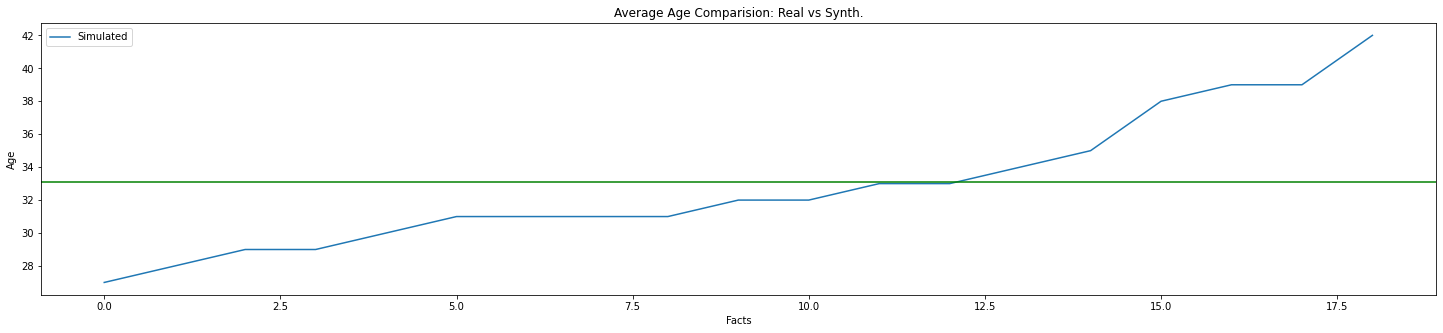

In [29]:
# Independent Continuous Data

ageList = listFloatToInt(getFiltteredData(getIndependentVariableData("hasIndependent", "Age")))
ageList = sorted(ageList)

avgAge = empDF["Age"].mean()
plt.figure(figsize=(25,5))
plt.plot(ageList, label='Simulated')
plt.axhline(y=avgAge, color='green')
plt.xlabel('Facts')
plt.ylabel('Age')
plt.title('Average Age Comparision: Real vs Synth.')
plt.legend()
plt.show()

In [36]:
# Partially Independent Continuous Data

print("Average salary of PhD in general is $72430 according to the Fact 8", )

print("The average salary of PhD in synthetic Data is:",empDF.loc[empDF['Education'] == "PhD"]['Salary'].mean())

Average salary of PhD in general is $72430 according to the Fact 8
The average salary of PhD in synthetic Data is: 67056.7337234004
